In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


# MODELE SIMPLE

In [3]:
nb_actifs = 20
nb_dates = 256 * 5

idx = pd.Index(np.arange(nb_actifs))

mu = pd.Series(0.05,index=idx)
vols = pd.Series(0.2,index=idx)
correl = 0.7

covar = np.diag(vols) @ pd.DataFrame(correl * np.ones((nb_actifs,nb_actifs)) + (1-correl) * np.eye(nb_actifs),index=idx,columns=idx) @ np.diag(vols)
A = np.linalg.cholesky(covar)

rdts_observes = mu/256 + pd.DataFrame(np.random.randn(nb_dates,nb_actifs)) @ A.T / 16

In [4]:
mu_estime = rdts_observes.mean() * 256
covar_estimee = rdts_observes.cov() * 256
alloc_optimale_in_sample = pd.DataFrame(np.linalg.inv(covar_estimee),index=idx,columns=idx) @ mu_estime

Sharpe = 2.2096987801433094


<AxesSubplot:>

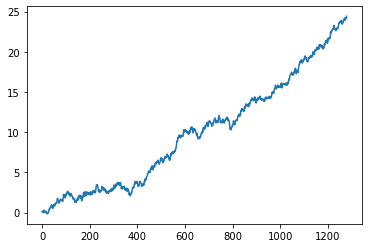

In [5]:
pnl_in_sample = rdts_observes @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_in_sample.mean()/pnl_in_sample.std()*16))
pnl_in_sample.cumsum().plot()

In [6]:
nb_nouvelles_dates = 256

Sharpe = -1.2336280778194644


<AxesSubplot:>

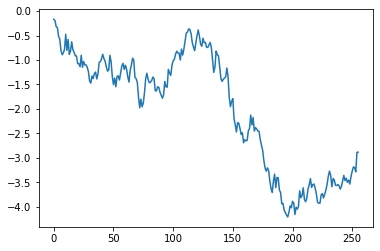

In [7]:
nouveaux_rdts = mu/256 + pd.DataFrame(np.random.randn(nb_nouvelles_dates,nb_actifs)) @ A.T / 16
pnl_out_sample = nouveaux_rdts @ alloc_optimale_in_sample
print('Sharpe = ' + str(pnl_out_sample.mean()/pnl_out_sample.std()*16))
pnl_out_sample.cumsum().plot()

In [8]:
nb_simu = 1000
pnls_out_sample = pd.DataFrame(mu @ alloc_optimale_in_sample /256 + (np.random.randn(nb_simu,nb_nouvelles_dates,nb_actifs) @ A.T @ alloc_optimale_in_sample.values/ 16)).T

In [9]:
sharpes_out_sample = pnls_out_sample.mean() / pnls_out_sample.std() * 16
sharpes_out_sample.describe()

count    1000.000000
mean        0.068889
std         1.037445
min        -2.828196
25%        -0.670292
50%         0.071159
75%         0.804549
max         3.174623
dtype: float64

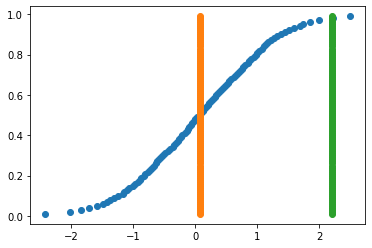

In [10]:
quantiles = sharpes_out_sample.quantile(np.arange(0.01,1.0,0.01)).reset_index().rename({'index':'proba',0:'quantile'},axis=1)
plt.scatter(quantiles['quantile'],quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + sharpes_out_sample.mean(),quantiles['proba'])
plt.scatter(quantiles['quantile']*0 + pnl_in_sample.mean()/pnl_in_sample.std()*16,quantiles['proba'])

# Modele plus avance

In [11]:
nb_signals = 100
nb_dates_in_sample = 1300
nb_dates_out_sample = 260
nb_assets = 80

vol_assets = 0.2/16
correl_assets = 0.8

# vol_signals = 1.0
# correl_signals = 0.0

vol_signals = 0.2/16
correl_signals = 0.8

signal_to_noise = 0.001

rank_betas = 5

cov_assets = vol_assets**2 * pd.DataFrame(correl_assets * np.ones((nb_assets,nb_assets)) + (1-correl_assets)*np.eye(nb_assets))
cov_signals = vol_signals**2 * pd.DataFrame(correl_signals * np.ones((nb_signals,nb_signals)) + (1-correl_signals)*np.eye(nb_signals))

betas = pd.DataFrame(np.random.randn(nb_signals,nb_assets))
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
u,d,v = np.linalg.svd(betas)
betas = pd.concat([pd.DataFrame(d[k] * np.outer(u[:,k],v[k,:]),index=betas.index,columns=betas.columns) for k in range(rank_betas)],keys=range(rank_betas)).groupby(level=1).sum()
betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
cov_noise = cov_assets - betas.T @ cov_signals @ betas
d,P = np.linalg.eigh(cov_noise)
cov_noise = pd.DataFrame(P @ np.diag(np.maximum(d,1e-10)) @ P.T)
print('signal to noise = ' + str(np.round(np.trace(betas.T @ cov_signals @ betas) / np.trace(cov_assets),3)))

sqrt_cov_assets = np.linalg.cholesky(cov_assets)
sqrt_cov_signals = np.linalg.cholesky(cov_signals)
sqrt_cov_noise = np.linalg.cholesky(cov_noise)

signal to noise = 0.001


5.543632916128394
0.22455045862278725


<AxesSubplot:>

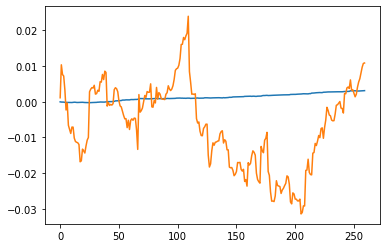

In [13]:
signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
assets = signals @ betas+noise

signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
assets_os = signals_os @ betas+noise_os

betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

w_theo = signals_os @ betas
pnl_theo = (w_theo * assets_os).sum(axis=1)

w_ols = signals_os @ betas_ols
pnl_ols = (w_ols * assets_os).sum(axis=1)

print(pnl_theo.mean()/pnl_theo.std()*16)
print(pnl_ols.mean()/pnl_ols.std()*16)

pnl_theo.cumsum().plot()
pnl_ols.cumsum().plot()

In [14]:
assets

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.014581,0.013365,0.013874,0.021167,0.026473,0.020671,0.024015,0.021111,0.013212,0.006103,...,0.010399,0.011546,0.019932,0.015660,0.014564,0.018218,0.014015,0.010473,0.021976,0.016567
1,-0.008328,-0.024844,-0.021371,-0.011998,-0.010485,-0.018163,-0.013969,-0.020864,-0.018251,-0.021552,...,-0.021757,-0.004873,-0.013841,-0.014662,-0.022405,-0.013326,-0.024541,-0.021309,-0.010194,-0.018183
2,0.001331,0.001817,0.012501,0.000279,0.001929,0.004089,0.002728,-0.000454,-0.006637,-0.000123,...,-0.000808,0.001577,-0.009028,-0.006468,-0.003376,-0.007616,0.007550,0.001620,-0.000646,0.007453
3,-0.019126,-0.011379,-0.017810,-0.016115,-0.020975,-0.015987,-0.018530,-0.024796,-0.016086,-0.022905,...,-0.018208,-0.015332,-0.019725,-0.011596,-0.010150,-0.020650,-0.025091,-0.001199,-0.020571,-0.013873
4,0.006371,-0.002269,0.006646,0.013537,0.008016,0.019080,0.016584,0.008419,0.013209,0.009578,...,0.007408,0.009397,0.007535,0.001970,0.010537,0.001819,0.002968,0.005996,0.000698,0.016348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,-0.007909,-0.012256,-0.017983,-0.018812,-0.000415,-0.013314,-0.011494,-0.018605,-0.019742,-0.018802,...,-0.011633,-0.014386,-0.011868,-0.014555,-0.013366,-0.013450,-0.016802,-0.011875,-0.008823,-0.020021
1296,0.014231,0.009014,0.013293,0.014890,0.017898,0.013056,0.009509,0.008523,0.013103,0.015691,...,0.010704,0.012310,0.010739,0.014565,0.022671,0.014616,0.021797,0.021459,0.015619,0.004842
1297,-0.001652,-0.006666,0.003608,0.002071,-0.007401,0.012102,-0.002653,-0.000228,0.001952,0.005553,...,0.005623,0.012156,-0.001531,0.002645,0.007013,0.001031,0.006486,0.010960,0.012847,-0.001786
1298,-0.016236,-0.015594,-0.011850,-0.008700,-0.013695,-0.010059,-0.011842,-0.014830,-0.008592,-0.017275,...,-0.019550,-0.018615,-0.021123,-0.024584,-0.015183,-0.014179,-0.010670,-0.026454,-0.025194,-0.019893


In [15]:
sharpes = {}
costs_break_even = {}
for i in range(1000):
    signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
    noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
    assets = signals @ betas+noise

    signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
    noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
    assets_os = signals_os @ betas+noise_os

    betas_ols = pd.DataFrame((np.linalg.inv(signals.T @ signals) @ signals.T @ assets).values,index=betas.index,columns=betas.columns)

    w_theo = signals_os @ betas
    pnl_theo = (w_theo * assets_os).sum(axis=1)

    w_ols = signals_os @ betas_ols
    pnl_ols = (w_ols * assets_os).sum(axis=1)

    sharpes[('theo',i)] = pnl_theo.mean()/pnl_theo.std()*16
    sharpes[('ols',i)] = pnl_ols.mean()/pnl_ols.std()*16

sharpes = pd.Series(sharpes).reset_index().rename({'level_0':'method','level_1':'simu',0:'sharpe'},axis=1)

In [16]:
pivot = sharpes.pivot_table(index='simu',columns='method')['sharpe']
means = pivot.mean()
quantiles = pivot.quantile(np.arange(0.01,1.0,0.01))

Text(0.5, 1.0, 'beta theo')

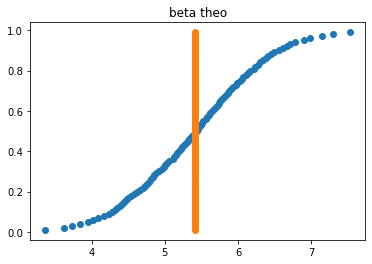

In [17]:
plt.scatter(quantiles['theo'],quantiles.index)
plt.scatter(quantiles['theo']*0+means['theo'],quantiles.index)
plt.title('beta theo')

Text(0.5, 1.0, 'beta ols')

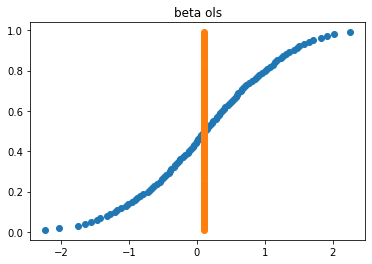

In [18]:
plt.scatter(quantiles['ols'],quantiles.index)
plt.scatter(quantiles['ols']*0+means['ols'],quantiles.index)
plt.title('beta ols')